# Find the central star of CTIO Data in May 2017
==================================================================================================

- author : Jérémy Neveu
- date   : May 31st 2017


The goal of this notebook is to cut a part of the image around the main central star.
The rest of the image is useless.
This region around the central star is necessary to perform the rotation of the images without
any biases due to other stars.


In [5]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print theNotebook

FindCentralStar


In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [8]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.2.0


In [9]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [10]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [11]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [12]:
%load_ext Cython

In [13]:
from IPython.display import Image, display

In [14]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [15]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [16]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)¶

In [17]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [18]:
ensure_dir(dir_top_images) # create that directory

### Input directory

In [19]:
!ls ../OverScanRemove/trim_images

trim_20170610_001.fits trim_20170610_048.fits trim_20170610_092.fits
trim_20170610_002.fits trim_20170610_049.fits trim_20170610_093.fits
trim_20170610_003.fits trim_20170610_050.fits trim_20170610_094.fits
trim_20170610_004.fits trim_20170610_051.fits trim_20170610_095.fits
trim_20170610_005.fits trim_20170610_052.fits trim_20170610_096.fits
trim_20170610_006.fits trim_20170610_053.fits trim_20170610_097.fits
trim_20170610_007.fits trim_20170610_054.fits trim_20170610_098.fits
trim_20170610_008.fits trim_20170610_055.fits trim_20170610_099.fits
trim_20170610_009.fits trim_20170610_056.fits trim_20170610_100.fits
trim_20170610_010.fits trim_20170610_057.fits trim_20170610_101.fits
trim_20170610_011.fits trim_20170610_058.fits trim_20170610_102.fits
trim_20170610_012.fits trim_20170610_059.fits trim_20170610_103.fits
trim_20170610_013.fits trim_20170610_060.fits trim_20170610_104.fits
trim_20170610_014.fits trim_20170610_061.fits trim_20170610_105.fits
trim_20170610_018.fits trim_201706

In [20]:
inputdir="../OverScanRemove/trim_images"
MIN_IMGNUMBER=21
MAX_IMGNUMBER=45
object_name='HD111980'
SelectTagRe='^trim_20170610_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170610_[0-9]+.fits$'
NBIMGPERLROW=4

### Output directory fot fits images

In [21]:
outputdir="./cut_fitsimages"

In [22]:
ensure_dir(outputdir)

## Location of corrected images
----------------------------------

In [23]:
input_filelist=os.listdir(inputdir) 

In [24]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [25]:
print input_filelist[:5]

['trim_20170610_001.fits' 'trim_20170610_002.fits' 'trim_20170610_003.fits'
 'trim_20170610_004.fits' 'trim_20170610_005.fits']


In [26]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list
dirlist_all = [inputdir]

In [27]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return 

In [28]:
MakeFileList()   # Make the list

In [29]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [30]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [31]:
sorted_numbers=indexes_files[sorted_indexes]

In [32]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

## Build full filename
----------------------------

In [33]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [34]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

## Acces to data of  images
----------------------------------

In [35]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt = []

In [36]:
%%cython

import numpy as np
from astropy.io import fits

def BuildImages(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawImages
    ===============
    """

    
    all_dates = []
    all_airmass = []
    all_images = []
    all_titles = []
    all_header = []
    all_filt = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
    
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()
        
    return all_dates,all_airmass,all_images,all_titles,all_header,all_filt

In [37]:
all_dates,all_airmass,all_images,all_titles,all_header,all_filt=BuildImages(sorted_files,sorted_numbers,object_name)

In [38]:
#all_filt

## Show images
-----------------------

In [39]:
len(all_images)

25

In [40]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,5*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=800)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)    
    figfilename=os.path.join(dir_top_images,'input_images.pdf')
    plt.savefig(figfilename)   

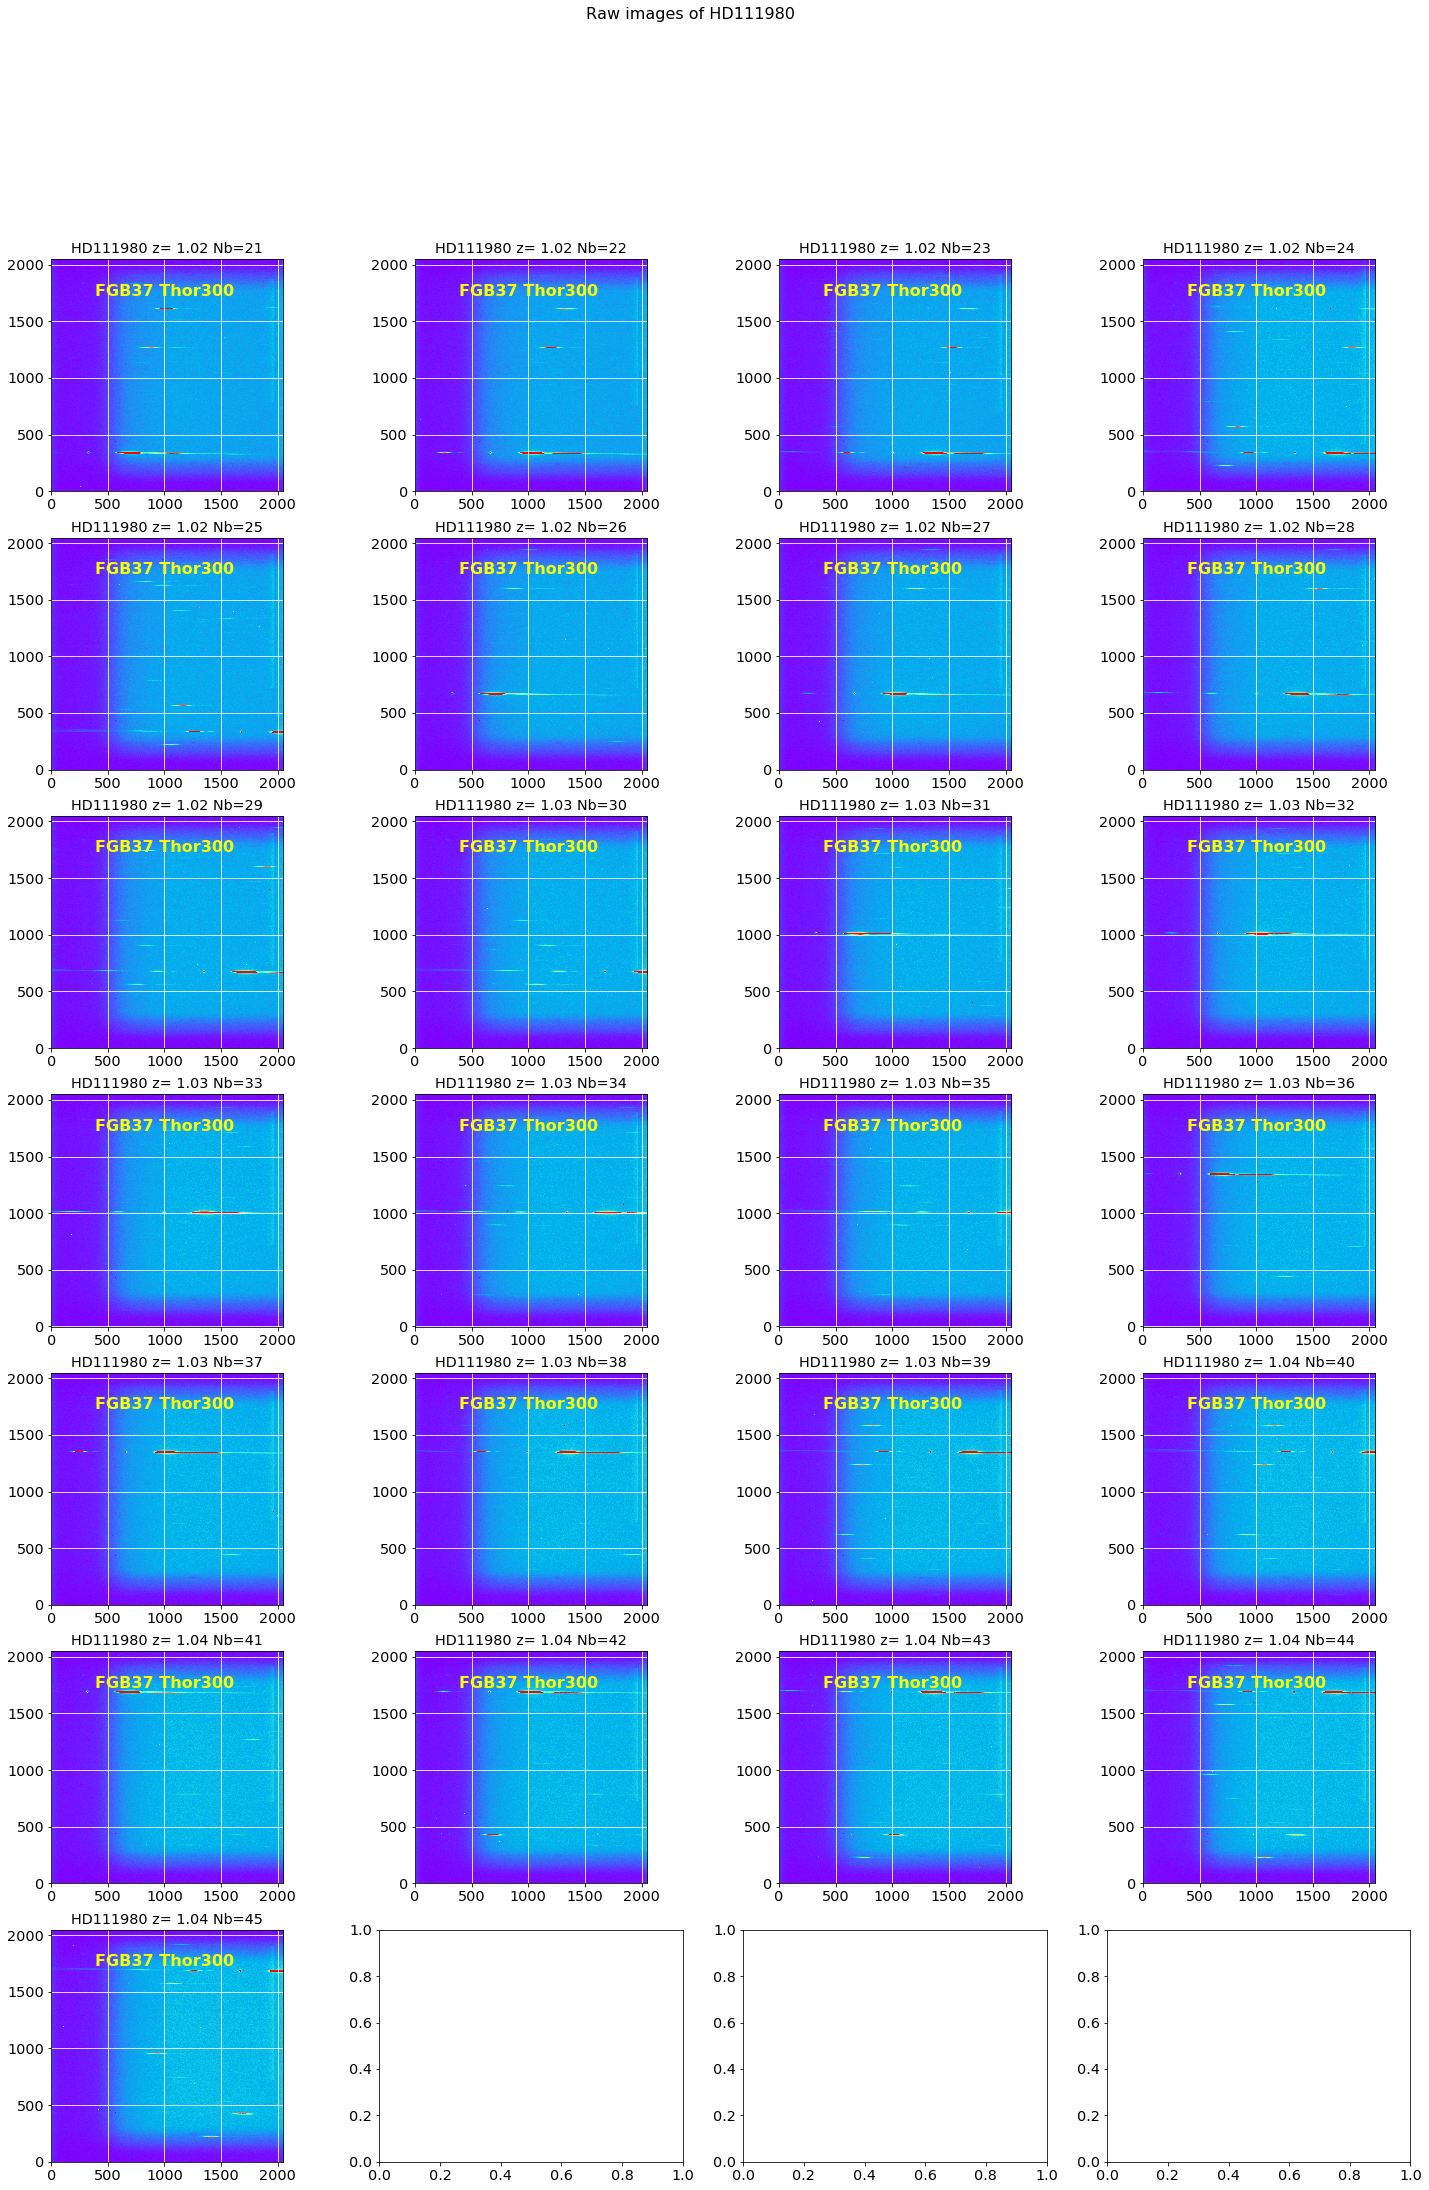

In [41]:
ShowRawImages()

### Find the star locations
----------------------------

In [56]:
%%cython
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind

def ComputeStatImages(all_images):
    """
    ComputeStatImages: 
    ==============
    """
    
    img_mean=[]
    img_median=[]
    img_std=[]
    img_sources=[]
    img_=[]
    index=0
    for image in all_images:
        mean, median, std = sigma_clipped_stats(image, sigma=10.0, iters=5)    
        print '----------------------------------------------------------------'
        print index,' mean, median, std = ',mean, median, std
        img_mean.append(mean)
        img_median.append(median)
        img_std.append(std)
        sources = daofind(image - median, fwhm=7, threshold=10*std) # (JN) valeurs optimisées pour cette étude
        print sources
        img_sources.append(sources)    
        index+=1
    return img_mean,img_median,img_std,img_sources

In [57]:
img_mean,img_median,img_std,img_sources=ComputeStatImages(all_images)

----------------------------------------------------------------
0  mean, median, std =  112.666378114 142.0 73.885958042


        Use DAOStarFinder instead. [astropy.utils.decorators]


 id   xcentroid     ycentroid   ...   peak       flux           mag      
--- ------------- ------------- ... ------- ------------- ---------------
  1 327.273838454 337.584986935 ... 49946.0 108.288847477  -5.08645932881
  2 488.683798468  1265.4825513 ...   848.0 2.01706171705 -0.761797966858
  3 639.496741547 1606.86641548 ...  1470.0 2.87137032106  -1.14522301783
----------------------------------------------------------------
1  mean, median, std =  112.698857852 142.0 74.0842230525
 id   xcentroid     ycentroid   ...   peak       flux           mag       
--- ------------- ------------- ... ------- ------------- ----------------
  1 663.474593052 335.916304827 ... 56748.0 107.318560645   -5.07668709822
  2 2022.26190998 733.259362351 ...   439.0 1.05152993198 -0.0545540986645
  3 824.767578565 1263.81867257 ...   936.0 1.81288524289  -0.645925784432
  4 975.563492383 1605.17210193 ...  1188.0 2.58701803117   -1.03199863926
---------------------------------------------------------

### Central star positions

In [58]:
x_star = []
y_star = []
mag_cut = -4
# loop to find star with highest peak value
for s in img_sources:
    max_peak = -1
    i_star = -1
    for iss,ss in enumerate(s) :
        if ss["mag"] > mag_cut : continue
        if ss["peak"] > max_peak :
            i_star = iss
            max_peak = ss["peak"]
    x_star.append(s[i_star]["xcentroid"])
    y_star.append(s[i_star]["ycentroid"])

In [59]:
positions_central = np.array([y_star, x_star]).T
print positions_central

[[  337.58498693   327.27383845]
 [  335.91630483   663.47459305]
 [  335.61018563   998.48854136]
 [  335.00744841  1335.23541197]
 [  334.47022571  1672.07250703]
 [  672.29210567   324.379424  ]
 [  671.77064403   662.23470531]
 [  671.25101855   999.12923363]
 [  671.1741751   1343.88968781]
 [  670.75335695  1669.89603507]
 [ 1008.15427843   324.34460788]
 [ 1007.40815186   660.11337488]
 [ 1007.96307595   996.42511264]
 [ 1006.9351876   1333.7799092 ]
 [ 1006.91778862  1668.95398187]
 [ 1346.02068612   322.02146091]
 [ 1345.64986315   656.41533114]
 [ 1345.07530782   993.01789564]
 [ 1345.55996284  1328.07998595]
 [ 1345.02462602  1665.9052836 ]
 [ 1682.87934543   318.59292148]
 [ 1682.17028869   654.05788535]
 [ 1681.50123885   989.9438577 ]
 [ 1679.65496507  1326.26938909]
 [ 1681.06257063  1663.064881  ]]


In [60]:
# Default position
x0 = x_star[len(img_sources)/2]
y0 = y_star[len(img_sources)/2]

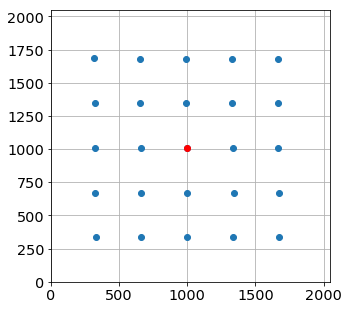

In [61]:
img_size=all_images[0].shape
plt.figure(figsize=(5,5))
plt.plot(x_star,y_star,'o')
plt.plot(x0,y0,'ro')
plt.xlim(0,img_size[1])
plt.ylim(0,img_size[0])
plt.grid(True)

### Cut the image

In [62]:
DeltaY=200
DeltaX=600

In [63]:
#%%cython

import numpy as np
import matplotlib.pyplot as plt
from photutils import CircularAperture
import os

def ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images):
    """
    ShowCenterImages: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    #global dir_top_images
    
    croped_images = []
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,3*MAXIMGROW))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        y0=int(positions_central[index][0])
        x0=int(positions_central[index][1])
       
        #image_cut=all_images[index][y0-200:y0+200,x0-200,y0+200]
        theimage=all_images[index]
        #image_cut=theimage[y0-DeltaY:y0+DeltaY,x0-DeltaX:x0+DeltaX]
        image_cut=np.copy(theimage[y0-DeltaY:y0+DeltaY,:])
        croped_images.append(image_cut)
        #aperture=CircularAperture([positions_central[index]], r=100.)
        im=axarr[iy,ix].imshow(image_cut,cmap='rainbow',vmin=0,vmax=1000,origin='lower',interpolation='None')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
        #aperture.plot(color='red', lw=5.)
    title='Cut Images of {}'.format(object_name)
    plt.suptitle(title,size=16) 
    
    figfilename=os.path.join(dir_top_images,'cut_images.pdf')
    plt.savefig(figfilename)   
    
    
    return croped_images

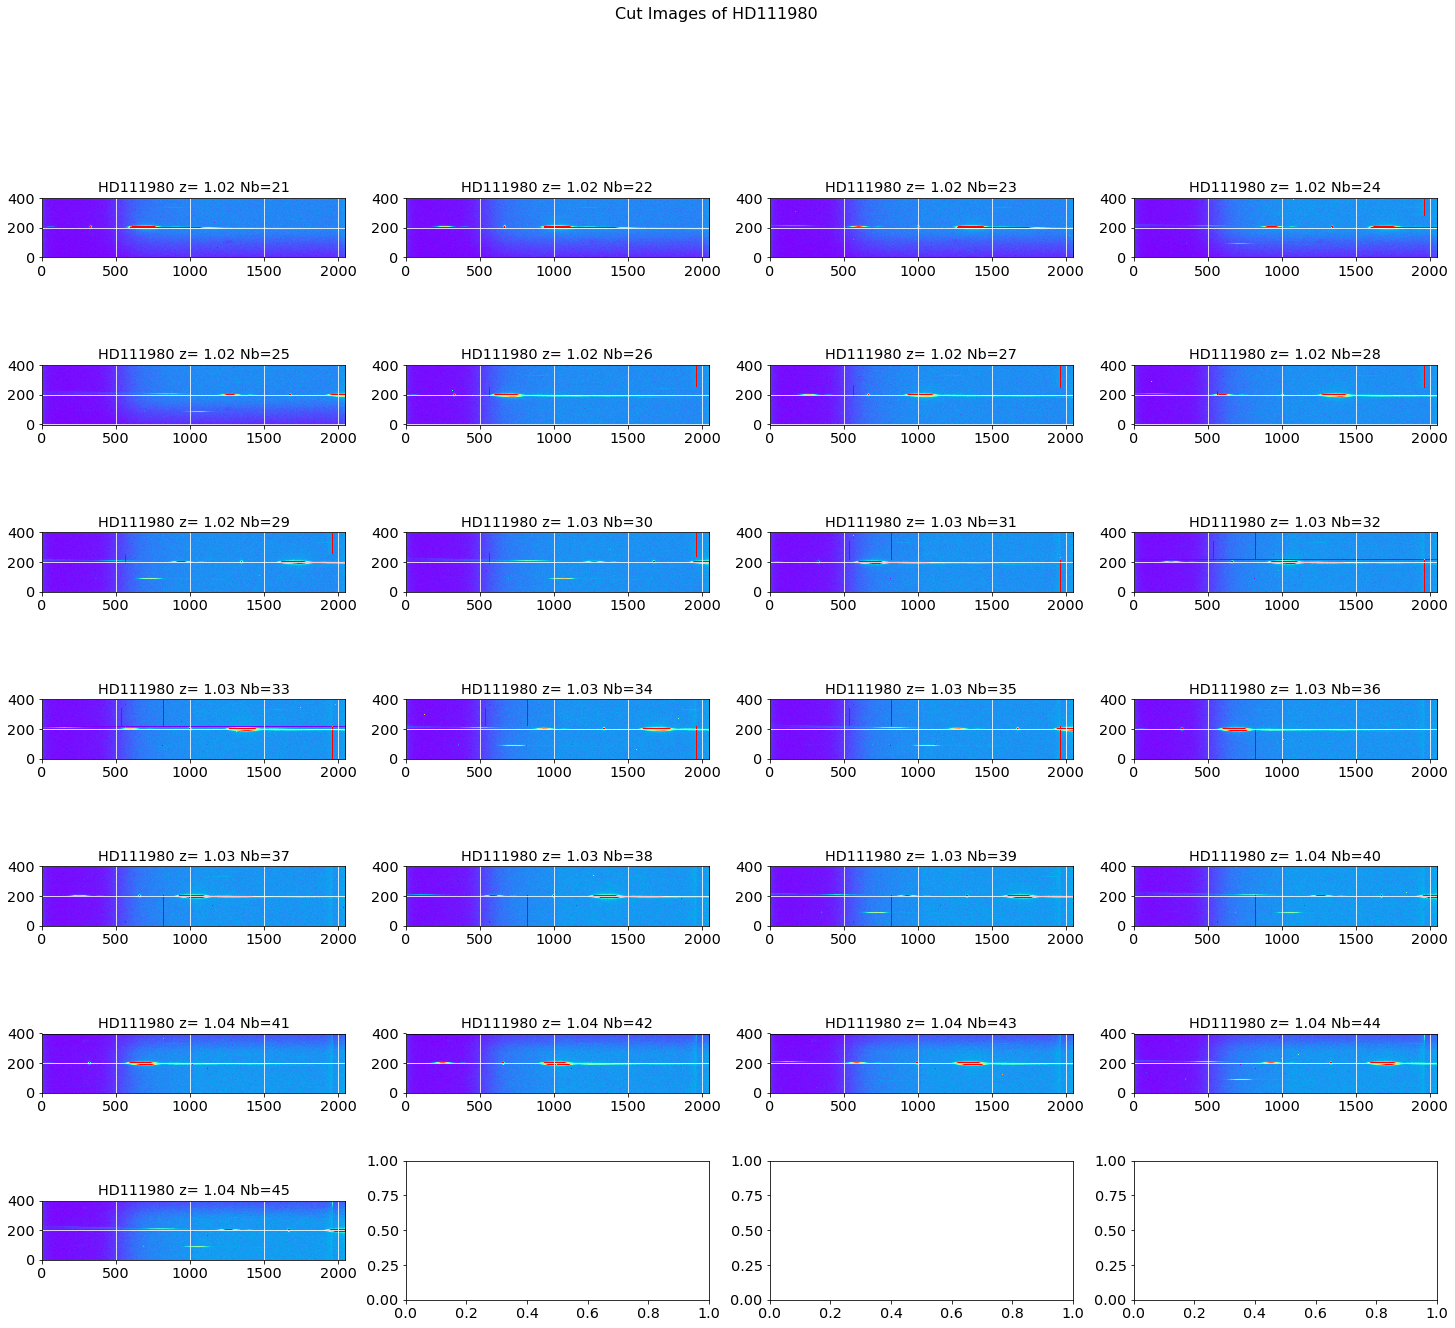

In [64]:
images_cut=ShowCenterImages(all_images,all_titles,object_name,positions_central,dir_top_images)

#### Example of cut image
-------------------------

In [65]:
index=0
data=np.copy(images_cut[index])
w=20
ws=80
#data[:,DeltaX-ws:DeltaX+ws]=0

In [66]:
yprofile=np.sum(data,axis=1)
xprofile=np.sum(data,axis=0)

In [67]:
y_center=np.where(yprofile==yprofile.max())[0][0]
print y_center

197


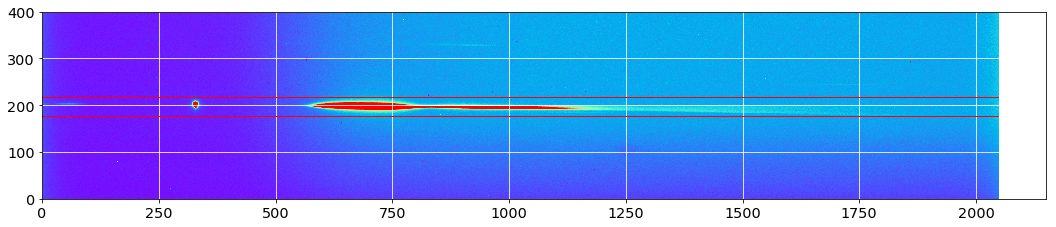

In [68]:
plt.figure(figsize=(18,18))
y0=int(positions_central[index][0])
x0=int(positions_central[index][1])
plt.imshow(data,vmin=-10,vmax=800,origin='lower',cmap='rainbow',interpolation='None')
plt.plot([0,data.shape[1]],[y_center-w,y_center-w],'r-',lw=1)
plt.plot([0,data.shape[1]],[y_center+w,y_center+w],'r-',lw=1)
plt.grid(color='white', ls='solid')
plt.show()
figfilename=os.path.join(dir_top_images,'cutimages_sample.pdf')
plt.savefig(figfilename)   

### prepare outputfilename

In [69]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    print short_infilename
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='cutimg_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

trim_20170610_021.fits
trim_20170610_022.fits
trim_20170610_023.fits
trim_20170610_024.fits
trim_20170610_025.fits
trim_20170610_026.fits
trim_20170610_027.fits
trim_20170610_028.fits
trim_20170610_029.fits
trim_20170610_030.fits
trim_20170610_031.fits
trim_20170610_032.fits
trim_20170610_033.fits
trim_20170610_034.fits
trim_20170610_035.fits
trim_20170610_036.fits
trim_20170610_037.fits
trim_20170610_038.fits
trim_20170610_039.fits
trim_20170610_040.fits
trim_20170610_041.fits
trim_20170610_042.fits
trim_20170610_043.fits
trim_20170610_044.fits
trim_20170610_045.fits


### Save outputfilename

In [70]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=images_cut[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)
textfilename=os.path.join(outputdir,'star_centroids.txt')
print textfilename
np.savetxt(textfilename,positions_central,header="y_star x_star",fmt='%d')

./cut_fitsimages/star_centroids.txt


In [71]:
!ls -l cut_fitsimages/*

-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_021.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_022.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_023.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_024.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_025.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_026.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_027.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_028.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_029.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_030.fits
-rw-r--r--  1 jneveu  staff  6566400 11 jui 08:24 cut_fitsimages/cutimg_20170610_031.fits
-rw-r--r--